# 1. 환경 설정 및 라이브러리/함수 정의

In [1]:
from google.colab import drive
import os
import sys
import numpy as np
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
from collections import OrderedDict
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models import vit_b_16, ViT_B_16_Weights, ResNet50_Weights

# 드라이브 마운트
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# --- Dataset Class ---
class MMOTUBinaryDataset(Dataset):
    def __init__(self, npz_path):
        super().__init__()
        data = np.load(npz_path)
        imgs = data["images"]
        labels = data["labels"]

        unique = np.unique(labels)
        if unique.max() > 1:
            labels = (labels == 7).astype(np.float32)
        else:
            labels = labels.astype(np.float32)

        self.images = imgs.astype(np.float32)
        self.labels = labels.astype(np.float32)

        if self.labels.ndim == 1:
            self.labels = self.labels[:, None]

        if self.images.ndim == 4 and self.images.shape[-1] in (1, 3):
            self.images = np.transpose(self.images, (0, 3, 1, 2))

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img = torch.from_numpy(self.images[idx])
        label = torch.from_numpy(self.labels[idx])
        return img, label

# --- Training & Eval Functions ---
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.numel()

    return running_loss / total, correct / total

@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        loss = criterion(logits, labels)

        running_loss += loss.item() * imgs.size(0)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.numel()

    return running_loss / total, correct / total

@torch.no_grad()
def eval_confusion(model, loader, device, threshold=0.5):
    model.eval()
    y_true, y_pred = [], []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        probs = torch.sigmoid(logits)
        preds = (probs > threshold).float()

        y_true.extend(labels.cpu().numpy().ravel())
        y_pred.extend(preds.cpu().numpy().ravel())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    f1 = f1_score(y_true, y_pred, zero_division=0)


    print(f"\n--- Evaluation at Threshold {threshold} ---")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Classification report:")
    print(classification_report(y_true, y_pred, digits=4))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda


# 2. 데이터 로드 및 DataLoader 설정

In [2]:
base_dir = Path("/content")

train_npz = base_dir / "train_augmented2_data.npz"
val_npz   = base_dir / "validation_data.npz"

if not train_npz.exists():
    print(f"Error: 파일을 찾을 수 없습니다. 경로를 확인해주세요: {train_npz}")
else:
    print("데이터 파일을 찾았습니다.")

    train_dataset = MMOTUBinaryDataset(train_npz)
    val_dataset   = MMOTUBinaryDataset(val_npz)

    # Class Imbalance 계산
    labels_np = np.array(train_dataset.labels).astype(int).ravel()
    neg = (labels_np == 0).sum()
    pos = (labels_np == 1).sum()

    print("Train benign(0):", neg)
    print("Train malignant(1):", pos)

    ratio = neg / pos
    pos_weight_value = ratio * 2
    print("pos_weight:", pos_weight_value)

    # Loss에 사용할 Weight
    pos_weight = torch.tensor([pos_weight_value], device=device)

    # DataLoader 설정 (pin_memory=True 반영)
    BATCH_SIZE = 16
    NUM_WORKERS = 2  # Colab에서는 2 정도가 안정적

    train_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              pin_memory=True)

    val_loader = DataLoader(val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=NUM_WORKERS,
                            pin_memory=True)

데이터 파일을 찾았습니다.
Train benign(0): 962
Train malignant(1): 950
pos_weight: 2.0252631578947367



# [모델 1] ResNet50 Binary

In [3]:

def build_resnet50_binary():
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 1)
    )
    return model

print(">>> Training ResNet50...")
model = build_resnet50_binary().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # 위에서 계산한 pos_weight 사용
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.01)

num_epochs = 20

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)

    print(f"[Epoch {epoch:02d}] "
          f"train loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"val loss={val_loss:.4f}, acc={val_acc:.4f}")

# 모델 저장 (드라이브 경로에 저장)
save_path = base_dir / "resnet50_binary_mmotu_2.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

# 최종 성능 평가 (Test Set 사용)
print("\n=== ResNet50 Test Set Evaluation ===")

eval_confusion(model, val_loader, device, threshold=0.5)
eval_confusion(model, val_loader, device, threshold=0.4)
eval_confusion(model, val_loader, device, threshold=0.3)
eval_confusion(model, val_loader, device, threshold=0.2)
eval_confusion(model, val_loader, device, threshold=0.1)

>>> Training ResNet50...
[Epoch 01] train loss=0.7263, acc=0.6475 | val loss=0.5128, acc=0.8849
[Epoch 02] train loss=0.1877, acc=0.9864 | val loss=0.1811, acc=0.9765
[Epoch 03] train loss=0.0540, acc=0.9969 | val loss=0.1682, acc=0.9765
[Epoch 04] train loss=0.0331, acc=0.9974 | val loss=0.1719, acc=0.9723
[Epoch 05] train loss=0.0196, acc=0.9995 | val loss=0.1741, acc=0.9723
[Epoch 06] train loss=0.0233, acc=0.9979 | val loss=0.2063, acc=0.9765
[Epoch 07] train loss=0.0202, acc=0.9984 | val loss=0.1997, acc=0.9723
[Epoch 08] train loss=0.0105, acc=0.9995 | val loss=0.2020, acc=0.9723
[Epoch 09] train loss=0.0082, acc=1.0000 | val loss=0.1942, acc=0.9744
[Epoch 10] train loss=0.0057, acc=1.0000 | val loss=0.2151, acc=0.9701
[Epoch 11] train loss=0.0065, acc=1.0000 | val loss=0.2178, acc=0.9723
[Epoch 12] train loss=0.0049, acc=1.0000 | val loss=0.1989, acc=0.9765
[Epoch 13] train loss=0.0040, acc=1.0000 | val loss=0.2155, acc=0.9765
[Epoch 14] train loss=0.0044, acc=1.0000 | val loss=

# [모델 2] ViT-B/16 Binary

In [10]:

# 1. 모델 정의
def build_vit_binary():
    weights = ViT_B_16_Weights.IMAGENET1K_V1
    model = vit_b_16(weights=weights)

    in_features = model.heads.head.in_features
    model.heads.head = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 1)
    )
    return model

# 2. 메인 실행 설정
base_dir = Path("/content")
train_npz = base_dir / "train_augmented2_data.npz"
val_npz   = base_dir / "validation_data.npz"

if not train_npz.exists():
    print(" 데이터 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
else:
    # Dataset & DataLoader
    train_dataset = MMOTUBinaryDataset(train_npz)
    val_dataset   = MMOTUBinaryDataset(val_npz)

    # Class Imbalance 계산
    labels_np = np.array(train_dataset.labels).astype(int).ravel()
    neg = (labels_np == 0).sum()
    pos = (labels_np == 1).sum()
    print("Train benign(0):", neg)
    print("Train malignant(1):", pos)

    ratio = neg / pos
    pos_weight_value = ratio * 2
    print("pos_weight:", pos_weight_value)

    pos_weight = torch.tensor([pos_weight_value], device=device)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

    # 모델 초기화
    print(">>> Training ViT...")
    model = build_vit_binary().to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=1e-5,
        weight_decay=0.01
    )

    # 학습 루프
    num_epochs = 20
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)

        print(f"[Epoch {epoch:02d}] train loss={train_loss:.4f}, acc={train_acc:.4f} | val loss={val_loss:.4f}, acc={val_acc:.4f}")

    # 모델 저장
    save_path = base_dir / "vit_b16_binary_mmotu_2.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")


# 최종 성능 평가 (Test Set 사용)
print("\n=== ViT Test Set Evaluation ===")

eval_confusion(model, val_loader, device, threshold=0.5)
eval_confusion(model, val_loader, device, threshold=0.4)
eval_confusion(model, val_loader, device, threshold=0.3)
eval_confusion(model, val_loader, device, threshold=0.2)
eval_confusion(model, val_loader, device, threshold=0.1)



Train benign(0): 962
Train malignant(1): 950
pos_weight: 2.0252631578947367
>>> Training ViT...
[Epoch 01] train loss=0.6014, acc=0.7636 | val loss=0.3088, acc=0.9339
[Epoch 02] train loss=0.1266, acc=0.9806 | val loss=0.1974, acc=0.9616
[Epoch 03] train loss=0.0373, acc=0.9979 | val loss=0.2026, acc=0.9701
[Epoch 04] train loss=0.0160, acc=1.0000 | val loss=0.2308, acc=0.9701
[Epoch 05] train loss=0.0114, acc=1.0000 | val loss=0.2385, acc=0.9701
[Epoch 06] train loss=0.0090, acc=1.0000 | val loss=0.2312, acc=0.9659
[Epoch 07] train loss=0.1044, acc=0.9686 | val loss=0.2550, acc=0.9318
[Epoch 08] train loss=0.0363, acc=0.9937 | val loss=0.2192, acc=0.9701
[Epoch 09] train loss=0.0342, acc=0.9932 | val loss=0.2267, acc=0.9744
[Epoch 10] train loss=0.0136, acc=0.9990 | val loss=0.2474, acc=0.9701
[Epoch 11] train loss=0.0060, acc=1.0000 | val loss=0.2470, acc=0.9765
[Epoch 12] train loss=0.0042, acc=1.0000 | val loss=0.2448, acc=0.9744
[Epoch 13] train loss=0.0040, acc=1.0000 | val loss=

# [모델 3] CNN + Transformer Hybrid

In [11]:
# 1. 모델 정의
class CNNTransformerHybrid(nn.Module):
    def __init__(self, d_model=512, nhead=8, num_layers=2, dim_feedforward=1024,
                 freeze_backbone=True, unfreeze_layer4=True, num_patches=49):
        super().__init__()
        backbone = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        self.backbone = nn.Sequential(OrderedDict([
    ("conv1", backbone.conv1),
    ("bn1", backbone.bn1),
    ("relu", backbone.relu),
    ("maxpool", backbone.maxpool),
    ("layer1", backbone.layer1),
    ("layer2", backbone.layer2),
    ("layer3", backbone.layer3),
    ("layer4", backbone.layer4),
]))
        self.backbone_out_channels = backbone.fc.in_features  # 2048

        self.token_proj = nn.Linear(self.backbone_out_channels, d_model)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + num_patches, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=0.1, batch_first=True, activation="gelu"
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

        self.classifier = nn.Sequential(
            nn.Linear(d_model, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False
            if unfreeze_layer4:
                for name, p in self.backbone.named_parameters():
                    if "layer4" in name:
                        p.requires_grad = True

    def forward(self, x):
        feat = self.backbone(x)
        B, C, H, W = feat.shape
        tokens = feat.flatten(2).permute(0, 2, 1)
        tokens = self.token_proj(tokens)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x_tokens = torch.cat([cls_tokens, tokens], dim=1)
        pos = self.pos_embed[:, : x_tokens.size(1), :]
        x_tokens = x_tokens + pos

        x_tokens = self.transformer(x_tokens)
        x_tokens = self.norm(x_tokens)

        patch_tokens = x_tokens[:, 1:, :]
        gap_feat = patch_tokens.mean(dim=1)
        return self.classifier(gap_feat)

# 2. 메인 실행 설정
base_dir = Path("/content")
train_npz = base_dir / "train_augmented2_data.npz"
val_npz   = base_dir / "validation_data.npz"

if not train_npz.exists():
    print("데이터 파일을 찾을 수 없습니다.")
else:
    train_dataset = MMOTUBinaryDataset(train_npz)
    val_dataset   = MMOTUBinaryDataset(val_npz)

    # Class Imbalance 계산
    labels_np = np.array(train_dataset.labels).astype(int).ravel()
    neg = (labels_np == 0).sum()
    pos = (labels_np == 1).sum()
    print("Train benign(0):", neg)
    print("Train malignant(1):", pos)

    ratio = neg / pos
    pos_weight_value = ratio
    print("pos_weight:", pos_weight_value)

    pos_weight = torch.tensor([pos_weight_value], device=device)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

    print(">>> Training Hybrid Model...")
    model = CNNTransformerHybrid().to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-5,
        weight_decay=0.01
    )

    num_epochs = 20
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)

        print(f"[Epoch {epoch:02d}] train loss={train_loss:.4f}, acc={train_acc:.4f} | val loss={val_loss:.4f}, acc={val_acc:.4f}")

    # 모델 저장
    save_path = base_dir / "cnn_transformer_hybrid_mmotu_2.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

# 최종 성능 평가 (Test Set 사용)
print("\n=== CNN+ViT Test Set Evaluation ===")

eval_confusion(model, val_loader, device, threshold=0.5)
eval_confusion(model, val_loader, device, threshold=0.4)
eval_confusion(model, val_loader, device, threshold=0.3)
eval_confusion(model, val_loader, device, threshold=0.2)
eval_confusion(model, val_loader, device, threshold=0.1)

Train benign(0): 962
Train malignant(1): 950
pos_weight: 1.0126315789473683
>>> Training Hybrid Model...
[Epoch 01] train loss=0.5032, acc=0.7835 | val loss=0.3343, acc=0.8998
[Epoch 02] train loss=0.1185, acc=0.9759 | val loss=0.1009, acc=0.9765
[Epoch 03] train loss=0.0420, acc=0.9932 | val loss=0.1000, acc=0.9744
[Epoch 04] train loss=0.0344, acc=0.9895 | val loss=0.1164, acc=0.9723
[Epoch 05] train loss=0.0198, acc=0.9969 | val loss=0.1021, acc=0.9723
[Epoch 06] train loss=0.0245, acc=0.9927 | val loss=0.1136, acc=0.9744
[Epoch 07] train loss=0.0088, acc=1.0000 | val loss=0.1081, acc=0.9744
[Epoch 08] train loss=0.0144, acc=0.9948 | val loss=0.1132, acc=0.9765
[Epoch 09] train loss=0.0273, acc=0.9922 | val loss=0.1102, acc=0.9744
[Epoch 10] train loss=0.0089, acc=0.9995 | val loss=0.1219, acc=0.9744
[Epoch 11] train loss=0.0116, acc=0.9969 | val loss=0.1202, acc=0.9723
[Epoch 12] train loss=0.0054, acc=1.0000 | val loss=0.1200, acc=0.9723
[Epoch 13] train loss=0.0075, acc=0.9990 | 

# 4. 시각화

In [12]:
def load_model(model_type, model_path, device):
    if model_type == "resnet":
        model = build_resnet50_binary()
    elif model_type == "vit":
        model = build_vit_binary()
    elif model_type == "hybrid":
        model = CNNTransformerHybrid()
    else:
        raise ValueError("Unknown model type")

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [13]:
@torch.no_grad()
def evaluate_model(model, loader, device):
    y_true, y_prob = [], []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        probs = torch.sigmoid(logits)

        y_true.extend(labels.cpu().numpy().ravel())
        y_prob.extend(probs.cpu().numpy().ravel())

    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = (y_prob > 0.5).astype(int)

    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1":       f1_score(y_true, y_pred, zero_division=0),
        "AUC":      roc_auc_score(y_true, y_prob),
        # 양성(악성) class = 1의 recall → Sensitivity
        "Sensitivity": recall_score(y_true, y_pred, pos_label=1)
    }
    return metrics


=== Model Evaluation on Test(=Val) Set ===

Evaluating ResNet50...
  Accuracy: 0.9787, F1: 0.5000, AUC: 0.8568, Sensitivity: 0.3333

Evaluating ViT-B/16...
  Accuracy: 0.9701, F1: 0.3636, AUC: 0.6956, Sensitivity: 0.2667

Evaluating Hybrid...
  Accuracy: 0.9787, F1: 0.5455, AUC: 0.8023, Sensitivity: 0.4000


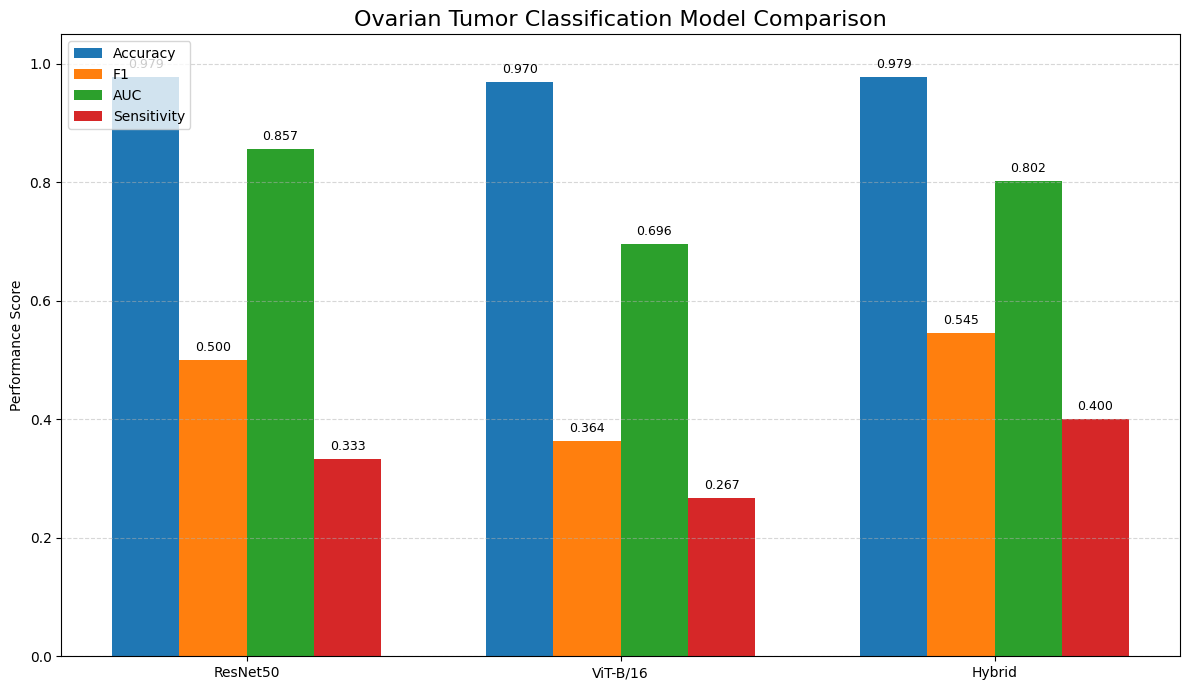

In [14]:
models_info = {
    "ResNet50": ("resnet", "/content/resnet50_binary_mmotu_2.pth"),
    "ViT-B/16": ("vit",    "/content/vit_b16_binary_mmotu_2.pth"),
    "Hybrid":   ("hybrid", "/content/cnn_transformer_hybrid_mmotu_2.pth")
}

results = {}
test_loader = val_loader

print("\n=== Model Evaluation on Test(=Val) Set ===")
for name, (mtype, path) in models_info.items():
    print(f"\nEvaluating {name}...")
    model = load_model(mtype, path, device)
    metrics = evaluate_model(model, test_loader, device)  # val_loader 재사용
    results[name] = metrics
    print(
        f"  Accuracy: {metrics['Accuracy']:.4f}, "
        f"F1: {metrics['F1']:.4f}, "
        f"AUC: {metrics['AUC']:.4f}, "
        f"Sensitivity: {metrics['Sensitivity']:.4f}"
    )

# === Plot ===
metrics_names = ["Accuracy", "F1", "AUC", "Sensitivity"]

model_names = list(results.keys())
metric_values = {
    m: [results[model][m] for model in model_names]
    for m in metrics_names
}

x = np.arange(len(model_names))
width = 0.18  # 막대 폭

plt.figure(figsize=(12, 7))

for i, metric in enumerate(metrics_names):
    bars = plt.bar(
        x + i * width,
        metric_values[metric],
        width,
        label=metric
    )
    # 각 막대 위에 수치 표기
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval + 0.01,
            f"{yval:.3f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

# x축 tick 위치를 가운데에 맞춰줌
center_offset = width * (len(metrics_names) - 1) / 2
plt.xticks(x + center_offset, model_names)

plt.ylabel("Performance Score")
plt.title("Ovarian Tumor Classification Model Comparison", fontsize=16)
plt.ylim(0, 1.05)
plt.legend(loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
